In [53]:
%matplotlib inline

import os
import tensorflow as tf
tf.set_random_seed(42)


import keras.backend.tensorflow_backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras import regularizers
from sklearn.preprocessing import *
import numpy as np
np.random.seed(42)
np.set_printoptions(threshold=10,linewidth=150)

import matplotlib.pyplot as plt

import argparse
import time
import pickle
import sys
import os
sys.path.append("../")

from physicsfuncs import Minv, cartesian_to_ptetaphi


In [2]:

def train_test_split(*args,**kwargs):
    train_size = 1.-kwargs.get("test_size", 0.5)
    for arg in args:
        n_total = arg.shape[0]
        n_train = int(train_size*n_total)
        train = arg[:n_train]
        test = arg[n_train-n_total:]
        yield train
        yield test
        
def get_mll_from_eptetaphi(x):
    return np.sqrt(2.*x[:,1]*x[:,5]*(np.cosh(x[:,2]-x[:,6])-np.cos(x[:,3]-x[:,7])))
print get_mll_from_eptetaphi(X_val_true_unsc)

In [155]:
data = np.load("data_xyz.npy")
X_total = data[:,range(1,1+8)]

use_pt_eta_phi = True
params = {
    "output_activation" : "sigmoid",
    "neck_dim" : 5,
    "node_geometry" : "100,50,30,10",
#     "node_geometry" : "30,20,10",
    "output_shape" : (8,),
    "activation" : "relu",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "batch_size": 256,
    "epochs": 5,
}

# convert to Eptetaphi
if use_pt_eta_phi:
    X_total = cartesian_to_ptetaphi(X_total)

print X_total
scaler = MinMaxScaler()
scaler.fit(X_total)
X_total = scaler.transform(X_total)

[[ 156.5763       96.05375644    1.07069622 ...,  124.68889814    1.67287048   -2.23026849]
 [  52.72488      45.47710145    0.55732902 ...,   46.63615894    0.66390589   -2.27015341]
 [  46.124324     44.03831489   -0.30658124 ...,   40.19973855   -1.13845094   -1.30189545]
 ..., 
 [  54.019653     35.47362132    0.98255151 ...,   14.71342911   -1.62396015   -0.8032189 ]
 [  34.446975     29.81992605   -0.55010225 ...,   66.08879878   -1.35930338    1.94711657]
 [  69.702903     44.47176092    1.0203773  ...,   52.93210118    0.98355605   -2.14424762]]


In [156]:
X_train, X_val = train_test_split(X_total, test_size=0.3)

In [157]:
print X_train[0]

[ 0.04627909  0.08291895  0.59422893  0.22841137  0.1009523   0.1767768   0.65281163  0.14504211]


In [158]:
def get_models(params):

    
        # define the autoencoder
    neck_dim = params["neck_dim"]
    output_shape = params["output_shape"]
    activation = params["activation"]
    node_geometry = params["node_geometry"]
    output_activation = params["output_activation"]
    
    
    # define the model
    inputs = Input(shape=output_shape)
    upper_geom = []
    for nodes in node_geometry.split(","):
        upper_geom.append({
            "nodes": int(nodes),
            "activation": activation,
            })
    print upper_geom

    encoded = None
    decoded = None
    for igeom,geom in enumerate(upper_geom):
        to_wrap = inputs if igeom == 0 else encoded
        encoded = Dense(geom["nodes"], activation=geom["activation"])(to_wrap)
    encoded = Dense(neck_dim , activation=activation, name="neck", activity_regularizer=regularizers.l1(1e-5))(encoded)
    for igeom,geom in enumerate(upper_geom[::-1]):
        to_wrap = encoded if igeom == 0 else decoded
        decoded = Dense(geom["nodes"], activation=geom["activation"])(to_wrap)
    decoded = Dense(output_shape[0] , activation=output_activation)(decoded)

    # AUTOENCODER
    autoencoder = Model(inputs, decoded)

    # ENCODER
    encoder = Model(inputs, encoded)

    # DECODER
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(neck_dim,))

    decoder_layer = None
    for ilay in range(-len(upper_geom)-1,0):
        to_wrap = encoded_input if ilay == -len(upper_geom)-1 else decoder_layer
        decoder_layer = autoencoder.layers[ilay](to_wrap)

    decoder = Model(encoded_input, decoder_layer)

    return autoencoder, encoder, decoder

In [159]:
ae, encoder, decoder = get_models(params)

[{'nodes': 100, 'activation': 'relu'}, {'nodes': 50, 'activation': 'relu'}, {'nodes': 30, 'activation': 'relu'}, {'nodes': 10, 'activation': 'relu'}]


In [160]:
ae.compile(optimizer=params["optimizer"], loss=params["loss"])
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 8)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               900       
_________________________________________________________________
dense_48 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_49 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_50 (Dense)             (None, 10)                310       
_________________________________________________________________
neck (Dense)                 (None, 5)                 55        
_________________________________________________________________
dense_51 (Dense)             (None, 10)                60        
__________

In [161]:
history = ae.fit(X_train, X_train,
        epochs = params["epochs"],
        batch_size = params["batch_size"],
        shuffle = True,
        validation_data = (X_val, X_val),
                verbose=2)

Train on 1049998 samples, validate on 450000 samples
Epoch 1/5
34s - loss: 0.3756 - val_loss: 0.3691
Epoch 2/5
33s - loss: 0.3690 - val_loss: 0.3688
Epoch 3/5
34s - loss: 0.3688 - val_loss: 0.3687
Epoch 4/5
34s - loss: 0.3686 - val_loss: 0.3687
Epoch 5/5
34s - loss: 0.3684 - val_loss: 0.3683


In [162]:
N = 100
func = Minv
if use_pt_eta_phi:
    func = get_mll_from_eptetaphi
mllreal = func(scaler.inverse_transform(X_val[:N]))
mllae = func(scaler.inverse_transform(ae.predict(X_val[:N])))
print mllreal
print mllae
print (mllreal-mllae).mean(), (mllreal-mllae).std()

[ 90.43729608  91.47363312  94.00211987 ...,  90.96239429  91.93654845  90.02327215]
[ 120.56008148   84.21842194   85.45379639 ...,   59.15916061   82.66790009   87.76174927]
2.72390056947 12.1324047502


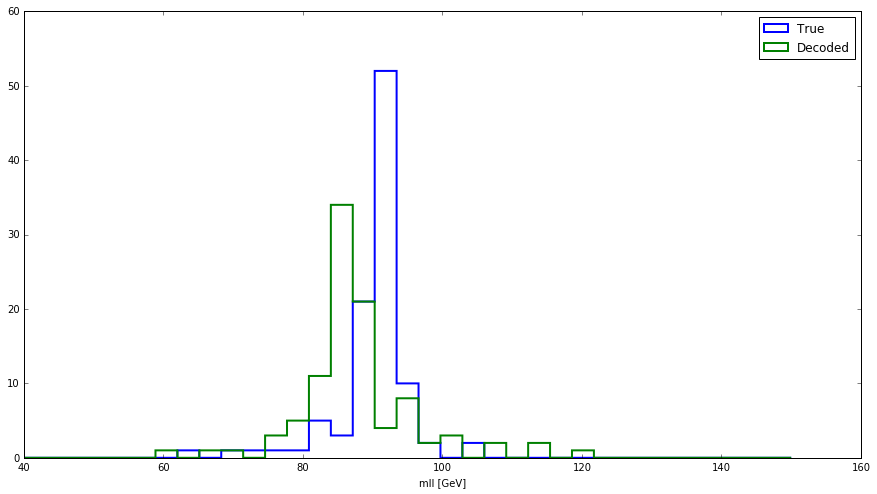

In [163]:


fig, ax = plt.subplots(1,1,figsize=(15,8))

idx = ic // ncols, ic % ncols
ax.hist(mllreal, range=(40,150),bins=35, histtype="step", lw=2)
ax.hist(mllae, range=(40,150),bins=35, histtype="step", lw=2)
ax.set_xlabel("mll [GeV]")
ax.legend(["True","Decoded"], loc='upper right')

In [164]:
X_val_true_unsc = scaler.inverse_transform(X_val)
print "transformed true"
X_val_ae_unsc = scaler.inverse_transform(ae.predict(X_val))
print "transformed ae"

print X_val_true_unsc
print X_val_ae_unsc


transformed true
transformed ae
[[  7.92006300e+01   6.24236364e+01  -7.17656217e-01 ...,   3.52331026e+01   9.66351723e-01   2.02137243e+00]
 [  8.97044600e+01   5.97193397e+01   9.64299100e-01 ...,   3.16460158e+01   5.99279213e-02  -2.91693324e-01]
 [  5.65368300e+01   3.92952073e+01   9.05514538e-01 ...,   5.51532692e+01   1.22626985e+00   1.88259371e+00]
 ..., 
 [  5.40196530e+01   3.54736213e+01   9.82551511e-01 ...,   1.47134291e+01  -1.62396015e+00  -8.03218899e-01]
 [  3.44469750e+01   2.98199261e+01  -5.50102245e-01 ...,   6.60887988e+01  -1.35930338e+00   1.94711657e+00]
 [  6.97029030e+01   4.44717609e+01   1.02037730e+00 ...,   5.29321012e+01   9.83556046e-01  -2.14424762e+00]]
[[  67.97809601   46.22080612   -0.63065213 ...,   41.71662903    1.59174156    1.99706137]
 [  76.55107117   41.01302338    1.13891888 ...,   41.07395172    0.37362671   -0.27980006]
 [ 101.23762512   41.97013092    1.35808849 ...,   42.57387543    1.05667734    1.87394404]
 ..., 
 [  52.99662018  

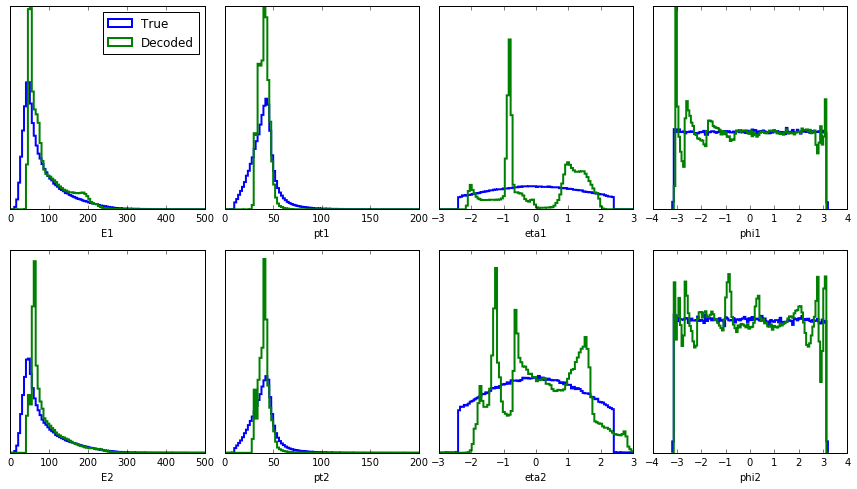

In [165]:
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows,ncols,figsize=(15,8))
fig.subplots_adjust(wspace=0.1)

# make plots of parameters. must match column ordering. second element is histo range.
if use_pt_eta_phi:
    info = [
        ("E1",(0,500)),
        ("pt1",(0,200)),
        ("eta1",(-3,3)),
        ("phi1",(-3.2,3.2)),
        ("E2",(0,500)),
        ("pt2",(0,200)),
        ("eta2",(-3,3)),
        ("phi2",(-3.2,3.2)),
    ]
else:
    info = [
        ("E1",(0,500)),
        ("px1",(-100,100)),
        ("py1",(-100,100)),
        ("pz1",(-100,100)),
        ("E2",(0,500)),
        ("px2",(-100,100)),
        ("py2",(-100,100)),
        ("pz2",(-100,100)),
    ]
for ic,(cname,crange) in enumerate(info):
    idx = ic // ncols, ic % ncols
    axs[idx].hist(X_val_true_unsc[:,ic], range=crange,bins=100, histtype="step", lw=2)
    axs[idx].hist(X_val_ae_unsc[:,ic], range=crange,bins=100, histtype="step", lw=2)
    axs[idx].set_xlabel(cname)
    axs[idx].get_yaxis().set_visible(False)
axs[0,0].legend(["True","Decoded"], loc='upper right')